# Assessed Exercise for Deep Learning (M)

This exercise must be submitted as a colab notebook. Deadline  Monday the 4th of March, 15:00.





You will create a classifier and test it on a collection of images for a new task. While you are welcome to build a full network from scratch, most of you will not have sufficient access to the data and compuational power required, so you are welcome to provide a solution based on transfer learning from a pre-trained network, adapted to your new task. 

The Keras documentation has some examples of pretrained networks which are easy to integrate, see for example  their ResNet50 example [https://keras.io/applications/#classify-imagenet-classes-with-resnet50](https://keras.io/applications/#classify-imagenet-classes-with-resnet50), or the InceptionV3 network  [https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes](https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes). If you use the pretrained model, a good way to start is by freezing all layers up to the last layer before the output. Adapt the output layer to fit your classification problem. You might then unfreeze some earlier layers for further fine tuning.

You will need to create a training set (at least 100 images per class, potentially classifying e.g type of location, activity. If you are training a full network from scratch you would need orders of magnitude more, but this will work for transfer learning on an existing network). It might be sensible to start off testing and demonstrating your approach by using an existing dataset e.g. 
the [flowers one](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/). You can find other interesting datasets at:
*   [http://deeplearning.net/datasets](http://deeplearning.net/datasets/)  
*   [UCI ML collection](https://archive.ics.uci.edu/ml/datasets.html)
*   [https://www.visualdata.io](https://www.visualdata.io)
*   [https://ai.google/tools/datasets](https://ai.google/tools/datasets/ )

Students who put more effort into creating and analysing an interesting dataset will tend to do better in marks for sections 1. & 2. below.

Write a pre-processing step that will resize and crop the images to the right size ((224, 224) is default for ResNet50 and (299,299) is the default for Inception), and consider how you can apply data augmentation techniques to your new dataset, and design appropriate pre-processing functions.

In your submission you should have the following structure (share of the AX marks given in brackets at the end of each part):

1.   Analysis of the problem. (15%)
2.   Visualisation and analysis of the data type, quality and  class distributions. You may want to design some data augmentation in your system. (20%)
3.   Creation of multiple candidate network architectures. Include your justification of the design decisions. You should inlcude one very simple baseline model (e.g. a linear model, or a simple two layer Densely connected model). (15%)
4.   Training. This should include code for hyperparameter search, regularisation methods. (15%)
5.   Empirical evaluation of performance, and potentially visualisation and  analysis of the trained network. This should make good use of graphs and tables of results, confusion matrices etc to represent the relative performance of the different models.  Explain why you chose the metrics you use. (20%)
6.   Report on the performance, discussing the suitability of the final network for use. (15%)

For each of the design decisions, make sure you describe in detail the motivation behind them. 

**Submission process**

You should submit the colab notebook with *all* code needed to run your model and all visualisations of results in place (I don't want to have to run 80 projects :-) ). This exercise must be submitted as a colab notebook. Deadline Monday the 4th of March, 15:00. If you have your own training data, make sure that any links to that are accessible by 3rd parties (me - I won't share the links with anyone else).

Share the Colab link (click on Share on top right of the Colab notebook, then 'Get shareable link') with me by e-mail [Roderick.Murray-Smith@glasgow.ac.uk](mailto:Roderick.Murray-Smith@glasgow.ac.uk?subject=Deep Learning AX 2019) and make sure that the Subject of the e-mail is *exactly* `'Deep Learning AX 2019'` (automatically generated if you click on the e-mail hyperlink above)

# Some code snippets which might be useful to get you started

In [1]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

Using TensorFlow backend.


# Additional Notebook Setup

## Google Drive Mounting

The following cell mounts the Google Drive where data is stored and sets the 'BASE_PATH' variable which points to this project folder. The "Cookiecutter Data Science" template has been used to structure the project.

In [2]:
path = os.getcwd()
BASE_PATH = "" # set manually if not using CoLab
print(path)
if path == '/content' or path == '/content/gdrive/My Drive/building_classifier':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/building_classifier/'
    os.chdir('/content/gdrive/My Drive/building_classifier/')
    
else:
    print("Please set BASE_PATH manually")

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports

In [3]:
# Image Processing
import glob
import cv2
from skimage.transform import resize

# Deep copying
from copy import deepcopy

# For custom DataGenerator
from keras.utils import Sequence, to_categorical

# For making sequantial models
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D

#VGG16
from keras.applications.vgg16 import VGG16

# used to count the number of cpus available for multiprocessing with DataGenerators 
import multiprocessing

# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# saving results
import pickle

# l2 regularization
from keras.regularizers import l2

  Cloning https://github.com/scikit-optimize/scikit-optimize/ to /tmp/pip-req-build-s49grjft
  Stored in directory: /tmp/pip-ephem-wheel-cache-3cljwaf6/wheels/66/66/b5/e1160753c1f4d7763be2755539df2c2ebd6e50f987dbea6abf
Successfully built scikit-optimize


# Analysis of the Problem

The aim of this project is to develop a classifier to identify buildings from the University of Glasgow. Such a model could then be embedded into a smartphone app to help navigation for new students at the University.

The main issue with the task is achieving a large enough dataset with enough variance to sufficiently train the model and allow it to generalize well. 

To be applicable for deployment the model must be able to identify a building from any point around it. Furthermore, the model should work in varying weather conditions.

It would not be practical to collect data for every building on campus and so this model has been limited to six buildings. This will serve as a proof of concept whilst keeping the time to collect the dataset feasible.

# Creating the Dataset

For the dataset, six buildings were chosen:


*   Boyd Orr
*   Adam Smith
*   Rankine
*   James Watt (South)
*   Main Building
*   Reading Room

These buildings were chosen as it provides a good mix of completely different architectures along with very similar designs. For example, the Adam Smith and Rankine building have a very similar exterior whilst the Main Building is completely different.

To generate the large amount of data needed to train the models, videos were taken of the buildings and the individual frames extracted. This does cause an issue as consecutive recorded frames are very similar. When choosing test sets it was ensured that this effect was kept to a minimum.

As the model is expected to work from any point around a building, when collecting the videos they were recorded from various points around the full building however due to limitations such as construction work and other buildings in the way this was not always possible.

To try and allow the model to handle various weather conditions full recordings of all six buildings were conducted on four different days.

The following table provides a description of the weather for each day:

Day     | Weather 
---|---
12/02/2019   | Cloudy      
14/02/2019   | Cloudy
15/02/2019  | Sunny
17/02/2019 | Cloudy w/ Sunny Intervals

It should be noted that the time of recording was very similar on each day at around 12:00. Therefore there are no evening videos recorded. To address this, online data augmentation is introduced later on. Furthermore, the weather variation is limited. For example, there are no videos of rain, snow or fog.

The videos were recorded at 720p using a mobile phone with no wide angle lens.


## Image Processing
The following code extracts the individual frames from the videos, crops them to a 720x720 then resizes them to 224x224.

Videos are stored in the format: */data/raw/'date_taken'/'building_name_number'.mp4*. For example: *"/data/raw/12_02_2019/adam_1.mp4"*

The extracted frames are stored in the format: */data/processed/'date_taken'/'building_name'/'number'.png*. For example: */data/processed/12_02_2019/adam/1.png*

It was noticed later that the colours of the images had been distorted during the processing (possibly due to a colour ordering difference). As the details of the images were unaltered this issue was not addressed and the images were not re-generated.

In [0]:
TARGET_IMAGE_SHAPE = (224, 224)
TARGET_IMAGE_FORMAT = '.png'
PROCESS_VIDEOS = False # set to false to prevent accidental overwriting

In [0]:
video_folders = ["12_02_2019", "14_02_2019", "15_02_2019", "17_02_2019"]

labels = ["rankine", "james", "main", "reading", "boyd", "adam"]

In [0]:
def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [0]:
PROCESSED_PATH = BASE_PATH + 'data/processed/'
make_path(PROCESSED_PATH)

In [0]:
# assumes landscape ratio (crops images to 720x720)
def crop_to_square(image):
    height = image.shape[0]
    width_centre = image.shape[1]/2
    start_width = int(width_centre - (height/2))
    end_width = int(width_centre + (height/2))
    return image[:,start_width:end_width,:]

In [0]:
if PROCESS_VIDEOS:
    for folder in video_folders:
        print("Processing Folder:", folder)

        VIDEO_PATH = BASE_PATH + 'data/raw/' + folder
        processed_folder_path = PROCESSED_PATH + folder + "/"
        make_path(processed_folder_path)

        count = 0 # variable used to give images different names 
        for path in glob.glob(VIDEO_PATH + "/*.mp4"):
            split_path = path.split("/")
            file_name = split_path[-1]
            split_file_name = file_name.split('_')
            building = split_file_name[0] 
            image_folder_path = processed_folder_path + building + '/'
            make_path(image_folder_path)

            vidcap = cv2.VideoCapture(path)
            success = 1
            while success:
                success, img = vidcap.read()  
                if success:
                    img = crop_to_square(img)
                    img = resize(img, TARGET_IMAGE_SHAPE) # resize 720x720 image to 224x224
                    save_path = image_folder_path + str(count) + TARGET_IMAGE_FORMAT
                    plt.imsave(save_path, img) # save image
                    count += 1

            print("Video Processed")

## Index File Creation
The following code creates an index to each picture location as the actual images are too large to store entirely in memory.

In [0]:
picture_folders = video_folders

In [0]:
file_index = {}
for folder in picture_folders:
    file_index[folder] = {}
    for label in labels:
        file_index[folder][label] = []
        
for path in glob.glob(PROCESSED_PATH + "*/*/*.png"):
    split_path = path.split("/")
    day = split_path[-3]
    building = split_path[-2]
    file = split_path[-1]
    file_index[day][building].append(path)

# Dataset Analysis

## Sample of Images
The following code plots a randomly selected group of six images for each building.
When plotting the images, it was realized that the colour scheme had been altered during processing. As the details were still intact it was chosen to continue without re-generating the dataset.

In [0]:
def plot_samples(selected_building, file_index):
    all_images_for_building = []
    for buildings in file_index.values():
        for building, imgs in buildings.items():
            if building == selected_building:
                for img in imgs:
                    all_images_for_building.append(img)
                    
    random_images = np.random.choice(all_images_for_building, size=6, replace=False)
    for i, img in enumerate(random_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(image.load_img(img))

### Boyd Orr

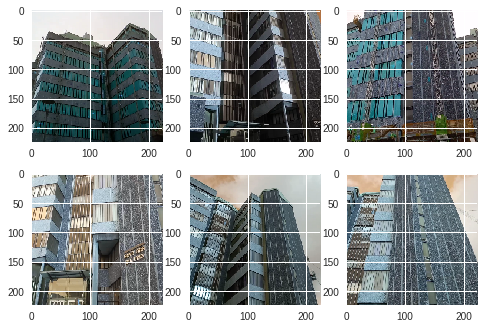

In [13]:
plot_samples("boyd", file_index)

### Adam Smith

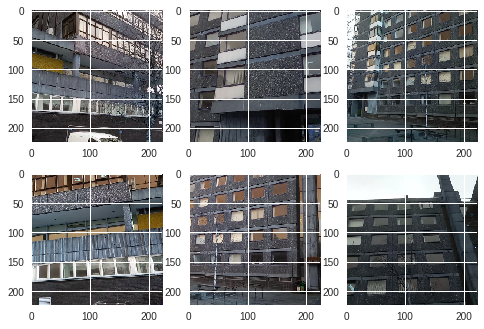

In [14]:
plot_samples("adam", file_index)

### Rankine

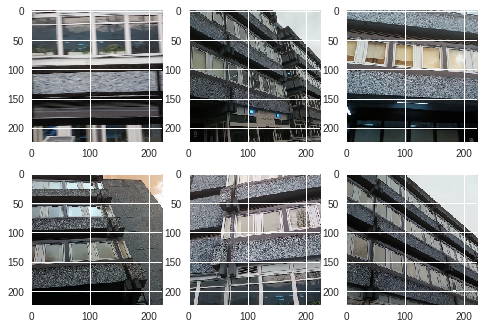

In [15]:
plot_samples("rankine", file_index)

### James watt (South)

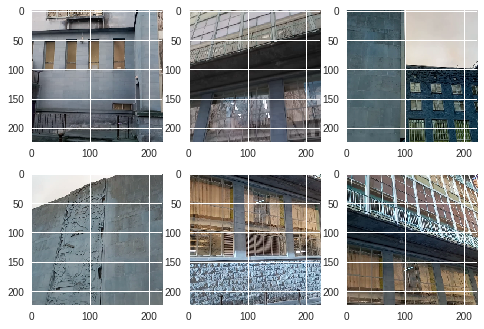

In [16]:
plot_samples("james", file_index)

### Main Building

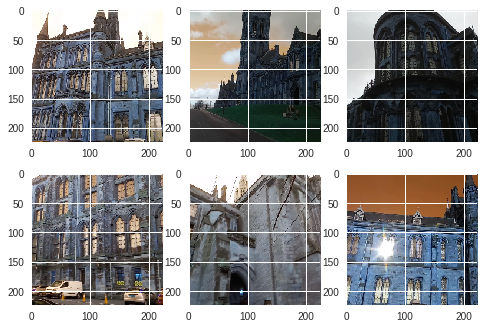

In [17]:
plot_samples("main", file_index)

### Reading Room

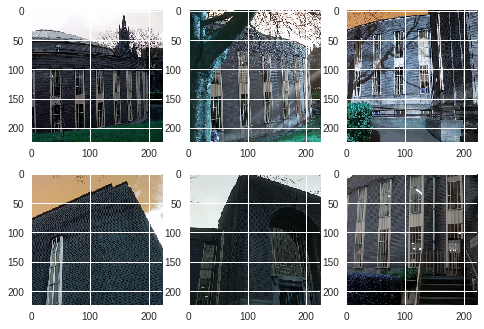

In [18]:
plot_samples("reading", file_index)

## The following functions are used for plotting the distribution of images per class.

In [0]:
def plot_subplot(file_index, day, axis, max_y):
    counts = {}
    for key, value in file_index[day].items():
        counts[key] = len(value)
        
    axis.bar(range(len(counts)), list(counts.values()), align='center')
    axis.set_title("Day: " + day)
    axis.set_xticks(range(len(counts)))
    axis.set_xticklabels(list(counts.keys()))
    axis.set_ylim(0, max_y)

In [0]:
def plot_day_distribution(index, picture_folders, max_y_val):
    f, axarr = plt.subplots(2, 2)
    plot_subplot(index, picture_folders[0] , axarr[0, 0], max_y_val)
    plot_subplot(index, picture_folders[1] , axarr[0, 1], max_y_val)
    plot_subplot(index, picture_folders[2] , axarr[1, 0], max_y_val)
    plot_subplot(index, picture_folders[3] , axarr[1, 1], max_y_val)

    for ax in axarr.flat:
        ax.set(xlabel='Building', ylabel='Number of Pictures')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()


In [0]:
max_y_val = 0
for folder in file_index.values():
    for count in folder.values():
        count = len(count)
        if count > max_y_val:
            max_y_val = count
            
max_y_val += 100

### Number of pictures per class (total)

In [0]:
def plot_total_distribution(index):
    type_counts = {
        "boyd": 0,
        "adam": 0,
        "reading": 0,
        "main": 0,
        "james": 0,
        "main": 0,
        "rankine": 0
    }
    
    for folder in index.values():
        for label, count in folder.items():
            type_counts[label] += len(count)
    
    plt.bar(range(len(type_counts)), list(type_counts.values()), align='center')
    plt.title("Total Pictures per Class")
    plt.xticks(range(len(type_counts)), list(type_counts.keys()))

## Distributions of the Dataset

### Figure 1: Picture Distribution per Day per Class

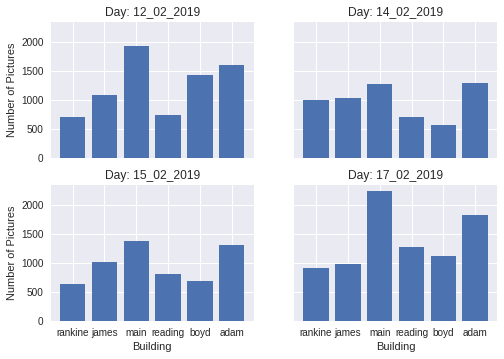

In [23]:
plot_day_distribution(file_index, picture_folders, max_y_val)

### Figure 2: Total Pictures per Class

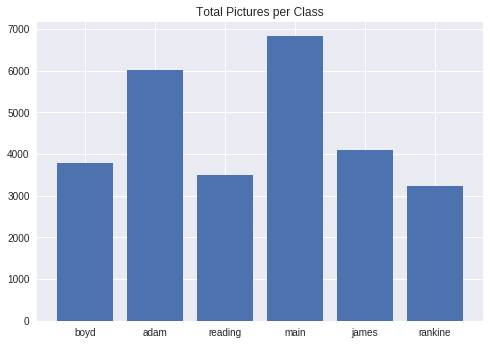

In [24]:
plot_total_distribution(file_index)

Figures 1 and 2 show that there is a clear class imbalance between the buildings. The Adam Smith and the University Main building have significantly more images (almost double) than the other buildings. If the model were to be trained directly on this data, then it would likely be biased towards the Adam Smith and Main building.

Figure 1 shows that there is a similar distribution over classes for each day.


## Handling the Class Imbalance
To handle this class imbalance, we will sub-sample the data.
Although this will result in a large loss of information, because the pictures were taken from videos, two consecutive frames contain almost identical information and so it is hoped by removing frames randomly it will limit the amount of information lost.

The data will be subsampled down to the length of the least represented category for each day. The sum-sampling is conducted by randomly removing the extra frames.

In [0]:
sub_sampled_index = deepcopy(file_index)

In [0]:
for folder in sub_sampled_index.keys():
    min_count = 0
    first = True
    # find minimum for day
    for label in labels:
        count = len(sub_sampled_index[folder][label])
        if first:
            min_count = count
            first = False
            
        else:
            if count < min_count:
                min_count = count
    for label in labels:
        arr = sub_sampled_index[folder][label]
        sub_sampled_index[folder][label] = np.random.choice(arr, min_count, replace=False)

In [0]:
max_y_val = 0
for folder in sub_sampled_index.values():
    for count in folder.values():
        count = len(count)
        if count > max_y_val:
            max_y_val = count
            
max_y_val += 100

### Figure 3: Sub-sampled Data Distribution per Class per Day

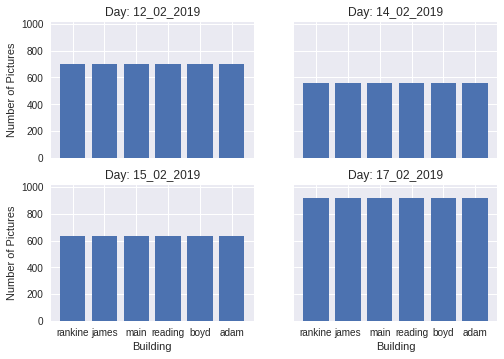

In [28]:
plot_day_distribution(sub_sampled_index, picture_folders, max_y_val)

### Figure 4: Total sub-sampled Class Distribution

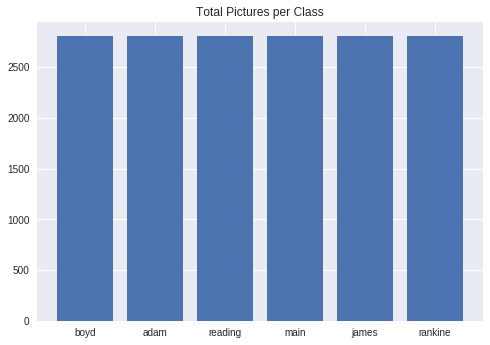

In [29]:
plot_total_distribution(sub_sampled_index)

As figures 3 and 4 show, after applying the sub-sampling there is an equal distribution for each class.

In [0]:
# As sub-sampling is conducted randomly, save file index for reproducible results.
SAVE_SUBSAMPLED = False
RESULTS_PATH = BASE_PATH + 'results/'
make_path(RESULTS_PATH)
SUBSAMPLED_PATH = RESULTS_PATH + "subsampled/"
make_path(SUBSAMPLED_PATH)

if SAVE_SUBSAMPLED:
    with open(SUBSAMPLED_PATH + "index.pkl", 'wb') as results_file:
        pickle.dump(sub_sampled_index, results_file)
        
with open(SUBSAMPLED_PATH + "index.pkl", 'rb') as results_file:
    sub_sampled_index = pickle.load(results_file)

# Data Generator Setup

A custom data generator was used for this task as the standard flow from directory can not be used to keep days separated.

The structure for the generator code was taken from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
. A similar version had already been implemented for my fourth year project.

---

**Data Augmentation**

To increase the amount of data available to the model, online data augmentation is used.  For each image, one of three augmentations, at a random level of intensity, is applied.

The three augmentations are:

* Image Zoom
* Brightness
* Rotation

Image zoom was used to try and help the model generalize to images taken closer up to the buildings. A negative zoom was considered but found to distort the image too much.

Brightness augmentation was used to try and simulate pictures taken in the evening (darker) and images that have been over exposed due to bright sunlight.

Rotation was used to simulate the input from a mobile app as it is likely to vary significantly depending on how the user is holding their phone. The rotation was limited to 80 degrees either way as past that the phone's autorotate would likely be activated. It is also unlikely that a user would take an image upside-down.

Translation was investigated but found to distort the image too much. Furthermore, as the images were extracted from a video, two consecutive frames introduce the effect of translation.

Mirroring of the image was not implemented as some buildings are not necessarily symmetrical.



In [0]:
'''Based on code from 
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
also similiar version used in fourth year project'''

class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, batch_size, dim, n_classes,
                 shuffle=False, augment=False):
        """Initialization"""
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment

        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def augment_image(self, img):
        mode = np.random.randint(0, 3)
        
        # brightness
        if mode == 0:
            return image.random_brightness(img, (0.5, 1.5))
            
        # rotation
        elif mode == 1:
            return image.random_rotation(img, 80,0,1,2)
        
        # zoom
        elif mode == 2:
            return image.random_zoom(img, (0.5,1.0), 0, 1, 2)

                    

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            img = image.load_img(ID)
            img = image.img_to_array(img)
            
            if self.augment:
                img = self.augment_image(img)
            
            # if the data is to be flattened (Simple Dense Model), only use grayscale
            if len(self.dim) == 1:
                img = img[:,:,1].flatten()
                
            X[i,] = img/255
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

In [32]:
# used for converting building labels to integers
conversion_table = {}
for index, label in enumerate(labels):
    conversion_table[label] = index

conversion_table

{'adam': 5, 'boyd': 4, 'james': 1, 'main': 2, 'rankine': 0, 'reading': 3}

# Candidate Network Architectures

Three initial model architectures were evaluated:


**Model 1**

The first model is a basic, fully connected, neural network with four layers.
The first layer uses 256 nodes followed by 128, 64 and finally 6 nodes to match the number of classes of buildings. This model was selected to provide a simple baseline on performance.

---

**Model 2**

Model 2 is the pretrained ResNet 50 model (trained on imagenet). This model was selected as the ResNet architecture had won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC)  in 2015. The 50 layer version of the model was selected due to the limited resources available.

---
**Model 3**

Model 3 is a smaller version of the VGG16 network. This model was selected as it was small enough that it was expected to be able to be trained from scratch whilst containing sufficient complexity to fully model the data. Initially no dropout was used.

## Model 1: Four Layer Dense Network
The network is designed to act as a simple benchmark. It has four layers of fully connected nodes. The input to this network only takes one flattened channel of the image. The ReLu activation has been chosen.

In [0]:
def four_layer_dense(input_shape, output_shape):
    model = Sequential(name="three_layer_dense")
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

## Model 2: ResNet 50

The original final layer of the model has been removed and replaced with an average pooling layer followed by a dense layer of 1024 nodes and finally a 6 node output layer for classification.

In [0]:
def res50(output_shape, pretrained=False):
    if pretrained:
        base_model = ResNet50(include_top=False, weights="imagenet", pooling="avg")
        
    else:
        base_model = ResNet50(include_top=False, weights=None, pooling="avg")
        
    x = Dense(1024, activation='relu')(base_model.output)
    predictions = Dense(output_shape, activation='softmax')(x)

    model = Model(base_model.input, predictions)
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

## Model 3: Downscaled VGG16

This model will not utilize transfer learning. Instead, it will learn all features based on the collected data. The use of dropout layers is also investigated.

In [0]:
def vgg16(input_shape, use_dropout=False, dropout=0.2):
    model = Sequential(name="test")

    model.add(Convolution2D(64, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(dropout))
        
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(dropout))

    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    
    return model

# Methods to Aid Visualization

In [0]:
def plot_accuracy(history, title):
    training = np.array(history["acc"])*100
    validation = np.array(history['val_acc' ])*100
    epoch_count = range(1, len(training) + 1)
    plt.plot(epoch_count, training, 'b--')
    plt.plot(epoch_count, validation, 'r-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.show()
    
def plot_loss(history, title):
    training = history["loss"]
    validation = history['val_loss' ]
    epoch_count = range(1, len(training) + 1)
    plt.plot(epoch_count, training, 'b--')
    plt.plot(epoch_count, validation, 'r-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

In [0]:
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Training
As the dataset was generated from videos, concurrent frames are very similar. Therefore, if the test set is randomly selected then it is very likely the model will be trained on almost identical images which will give misleadly high results.

To solve this, the data collected on the 14/02/2019 will be used exclusively for the final evaluation of the model as it contains the least number of photos after the sub-sampling process. Up until the final evaluation the models will not be exposed to this data.

For training the models the remaining days will be used. When validating the models they will be trained on two of the training days and validated on the third day.

Train | Test
--|--
12/02/2019 | 14/02/2019
15/02/2019|
17/02/2019|

In [0]:
def compute_confusion_matrix(val_generator, index, predictions):
    predictions = np.argmax(predictions,axis=1)
    true_labels = []
    for img in val_generator.list_IDs:
        true_labels.append(index[img])
        
    true_labels = np.array(true_labels)
    true_labels = true_labels[:len(predictions)]
        
    return confusion_matrix(true_labels, predictions)


In [0]:
def evaluate_model(model, epochs, train, val, complete_index, input_size, batch_size, output_size):
    train_generator = DataGenerator(train, complete_index, batch_size,
                                    input_size, output_size, shuffle=True,
                                    augment=True)
    val_generator = DataGenerator(val, complete_index, batch_size,
                                  input_size, output_size, shuffle=False,
                                  augment=False)
    
    history = model.fit_generator(generator=train_generator,
                                  validation_data=val_generator,
                                  use_multiprocessing=True,
                                  workers=multiprocessing.cpu_count(),
                                  epochs=epochs,
                                  verbose=1)
    
    predictions = model.predict_generator(val_generator,
                                    workers=multiprocessing.cpu_count(),
                                    use_multiprocessing=True, verbose=1)
    
    conf_matrix = compute_confusion_matrix(val_generator, complete_index, predictions)
    return {
        "confusion_matrix": conf_matrix,
        "history": history.history
    }

## Model Comparison

For the model comparison, each model will be trained on the data collected from days 12/02/2019 and 17/02/2019 whilst the data collected on the 15/02/2019 will be used for validation.

In [0]:
# Used to prevent overwriting of results
RUN_MODEL_1 = False
SAVE_RESULTS_MODEL_1 = False

RUN_MODEL_2 = False
SAVE_RESULTS_MODEL_2 = False

RUN_MODEL_3 = False
SAVE_RESULTS_MODEL_3 = False

RUN_MODEL_3_dropout = False
SAVE_RESULTS_MODEL_3_dropout = False

RUN_MODEL_3_dropout_aggressive = False
SAVE_RESULTS_MODEL_3_dropout_aggressive = False

In [0]:
epochs = 10
batch_size = 64

In [0]:
# Create folder to save results
RESULTS_PATH_INITIAL = RESULTS_PATH + 'initial_investigation/'
make_path(RESULTS_PATH_INITIAL)

In [0]:
data = deepcopy(sub_sampled_index)
#Remove test day as used only for the final evalaution
del data["14_02_2019"]

In [0]:
complete_index = {}
partition = {'train':[], 'validation':[]} # contains list of training and validation ID's
validation_day = "15_02_2019" # use this day for validation

for day, buildings in data.items():
    for building, images in buildings.items():
        for img in images:
            if day == validation_day:
                partition["validation"].append(img)
                complete_index[img] = conversion_table[building]

            else:
                partition["train"].append(img)
                complete_index[img] = conversion_table[building]

In [0]:
confusion_labels = []
for i in range(7):
    for building, value in conversion_table.items():
        if i == value:
            confusion_labels.append(building)

### Model 1 (Four Layer Dense)

In [0]:
input_shape = TARGET_IMAGE_SHAPE[0] ** 2 # only use grayscale to reduce training time

In [41]:
model = four_layer_dense((input_shape,), len(labels))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_1:
    results = evaluate_model(model, epochs,
                             partition["train"], partition["validation"],
                             complete_index, (input_shape,),
                             batch_size, len(labels))

Epoch 1/10
151/151 [==============================] - 1936s 13s/step - loss: 4.1399 - acc: 0.2168 - val_loss: 1.9644 - val_acc: 0.2246
Epoch 2/10
151/151 [==============================] - 116s 769ms/step - loss: 1.8364 - acc: 0.2569 - val_loss: 1.7801 - val_acc: 0.2783
Epoch 3/10
151/151 [==============================] - 114s 758ms/step - loss: 1.7782 - acc: 0.2843 - val_loss: 1.8237 - val_acc: 0.2852
Epoch 4/10
151/151 [==============================] - 115s 761ms/step - loss: 1.6884 - acc: 0.3119 - val_loss: 1.8651 - val_acc: 0.3120
Epoch 5/10
151/151 [==============================] - 114s 754ms/step - loss: 1.6797 - acc: 0.3220 - val_loss: 1.7647 - val_acc: 0.3038
Epoch 6/10
151/151 [==============================] - 116s 767ms/step - loss: 1.6573 - acc: 0.3282 - val_loss: 1.7160 - val_acc: 0.3167
Epoch 7/10
151/151 [==============================] - 115s 761ms/step - loss: 1.6266 - acc: 0.3385 - val_loss: 1.7404 - val_acc: 0.2709
Epoch 8/10
151/151 [=============================

In [0]:
if SAVE_RESULTS_MODEL_1:
    with open(RESULTS_PATH_INITIAL + "model_1.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Model 2 (ResNet50)

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

#### Using pretrained weights
It was found that freezing the the bottom layers does not work (gives very high training accuracy but as good as random validation accuracy). This is due to the batchnormalization layers and is discussed in 
[Keras Issue 9214](https://github.com/keras-team/keras/issues/9214).
To overcome this, all batch normalization layers have been unfrozen according to [Stackoverflow high acc, low val-acc ](https://stackoverflow.com/questions/53134404/keras-transfer-learning-resnet50-using-fit-generator-got-high-acc-but-low-val-ac). The last two blocks of the ResNet 50 model have also been unfrozen.

In [74]:
# returned model has all base layers frozen
model = res50(len(labels), pretrained=True)

# unfreeze batch normalization layers
for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        
# unfreeze top two blocks of ResNet
for layer in model.layers[155:]:
        layer.trainable = True
        
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_2:
    results = evaluate_model(model, epochs,
                               partition["train"], partition["validation"],
                               complete_index, input_shape,
                               batch_size, len(labels))

Epoch 1/10
151/151 [==============================] - 252s 2s/step - loss: 0.0593 - acc: 0.9808 - val_loss: 0.2266 - val_acc: 0.9656
Epoch 2/10
151/151 [==============================] - 230s 2s/step - loss: 0.0208 - acc: 0.9958 - val_loss: 0.0785 - val_acc: 0.9770
Epoch 3/10
151/151 [==============================] - 229s 2s/step - loss: 0.0056 - acc: 0.9984 - val_loss: 0.0235 - val_acc: 0.9921
Epoch 4/10
151/151 [==============================] - 230s 2s/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0608 - val_acc: 0.9857
Epoch 5/10
151/151 [==============================] - 230s 2s/step - loss: 6.3170e-04 - acc: 0.9999 - val_loss: 0.0133 - val_acc: 0.9963
Epoch 6/10
151/151 [==============================] - 230s 2s/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0237 - val_acc: 0.9923
Epoch 7/10
151/151 [==============================] - 232s 2s/step - loss: 0.0076 - acc: 0.9983 - val_loss: 2.2612 - val_acc: 0.8403
Epoch 8/10
151/151 [==============================] - 230s 2s/ste

In [0]:
if SAVE_RESULTS_MODEL_2:
    with open(RESULTS_PATH_INITIAL + "model_2.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Model 3 (VGG16)

#### No Dropout

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [39]:
model = vgg16(input_shape, use_dropout=False)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_3:
    results = evaluate_model(model, epochs, partition["train"], partition["validation"],
                             complete_index, input_shape, batch_size, len(labels))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
151/151 [==============================] - 1291s 9s/step - loss: 1.8042 - acc: 0.2391 - val_loss: 1.6320 - val_acc: 0.3112
Epoch 2/10
151/151 [==============================] - 237s 2s/step - loss: 1.3097 - acc: 0.4825 - val_loss: 1.3444 - val_acc: 0.4632
Epoch 3/10
151/151 [==============================] - 235s 2s/step - loss: 0.8068 - acc: 0.6966 - val_loss: 1.2797 - val_acc: 0.5898
Epoch 4/10
151/151 [==============================] - 236s 2s/step - loss: 0.5091 - acc: 0.8168 - val_loss: 1.5210 - val_acc: 0.6184
Epoch 5/10
151/151 [==============================] - 235s 2s/step - loss: 0.3536 - acc: 0.8778 - val_loss: 1.7071 - val_acc: 0.6600
Epoch 6/10
151/151 [==============================] - 236s 2s/step - loss: 0.2492 - acc: 0.9170 - val_loss: 1.9444 - val_acc: 0.6772
Epoch 7/10
151/151 [==============================] - 234s 2s/step - loss: 0.1830

In [0]:
if SAVE_RESULTS_MODEL_3:
    with open(RESULTS_PATH_INITIAL + "model_3.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

#### Dropout: 0.2
The epochs have been increased by 5 to allow for the dropout. 

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [40]:
model = vgg16(input_shape, use_dropout=True, dropout=0.2)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_3_dropout:
    results = evaluate_model(model, epochs+5, partition["train"], partition["validation"],
                             complete_index, input_shape, batch_size, len(labels))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
151/151 [==============================] - 722s 5s/step - loss: 1.7677 - acc: 0.2667 - val_loss: 1.5950 - val_acc: 0.3557
Epoch 2/15
151/151 [==============================] - 245s 2s/step - loss: 1.1512 - acc: 0.5476 - val_loss: 1.7165 - val_acc: 0.4290
Epoch 3/15
151/151 [==============================] - 244s 2s/step - loss: 0.9013 - acc: 0.6542 - val_loss: 1.2986 - val_acc: 0.5853
Epoch 4/15
151/151 [==============================] - 246s 2s/step - loss: 0.6457 - acc: 0.7633 - val_loss: 1.5083 - val_acc: 0.5874
Epoch 5/15
151/151 [==============================] - 246s 2s/step - loss: 0.4975 - acc: 0.8211 - val_loss: 1.8400 - val_acc: 0.6367
Epoch 6/15
151/151 [==============================] - 250s 2s/step - loss: 0.3456 - acc: 0.8812 - va

In [0]:
if SAVE_RESULTS_MODEL_3_dropout:
    with open(RESULTS_PATH_INITIAL + "model_3_dropout.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Dropout: 0.5
As with the dropout of 0.2 the epochs have been increased by 5

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [77]:
model = vgg16(input_shape, use_dropout=True, dropout=0.5)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_3_dropout_aggressive:
    results = evaluate_model(model, epochs+5, partition["train"], partition["validation"],
                             complete_index, input_shape, batch_size, len(labels))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
151/151 [==============================] - 266s 2s/step - loss: 1.8581 - acc: 0.1635 - val_loss: 1.7918 - val_acc: 0.1674
Epoch 2/15
151/151 [==============================] - 241s 2s/step - loss: 1.7919 - acc: 0.1615 - val_loss: 1.7917 - val_acc: 0.1674
Epoch 3/15
151/151 [==============================] - 240s 2s/step - loss: 1.7919 - acc: 0.1644 - val_loss: 1.7917 - val_acc: 0.1674
Epoch 4/15
151/151 [==============================] - 239s 2s/step - loss: 1.7919 - acc: 0.1594 - val_loss: 1.7917 - val_acc: 0.1674
Epoch 5/15
151/151 [==============================] - 238s 2s/step - loss: 1.7919 - acc: 0.1560 - val_loss: 1.7918 - val_acc: 0.1674
Epoch 6/15
151/151 [==============================] - 237s 2s/step - loss: 1.7919 - acc: 0.1606 - va

In [0]:
if SAVE_RESULTS_MODEL_3_dropout_aggressive:
    with open(RESULTS_PATH_INITIAL + "model_3_dropout_aggressive.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Comparison of Results

In [0]:
with open(RESULTS_PATH_INITIAL + "model_1.pkl", 'rb') as results_file:
    model_1_results = pickle.load(results_file)
    
with open(RESULTS_PATH_INITIAL + "model_2.pkl", 'rb') as results_file:
    model_2_results = pickle.load(results_file)
    
with open(RESULTS_PATH_INITIAL + "model_3.pkl", 'rb') as results_file:
    model_3_results = pickle.load(results_file)
    
with open(RESULTS_PATH_INITIAL + "model_3_dropout.pkl", 'rb') as results_file:
    model_3_dropout_results = pickle.load(results_file)
    
with open(RESULTS_PATH_INITIAL + "model_3_dropout_aggressive.pkl", 'rb') as results_file:
    model_3_dropout_aggressive_results = pickle.load(results_file)

#### Comparison of Validation Accuracy

The following graph shows the validation accuracy for each model over the epochs.

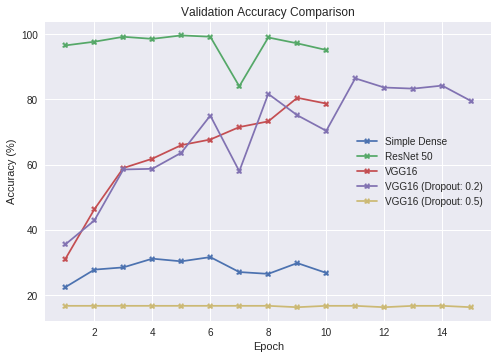

In [80]:
model_1 = np.array(model_1_results["history"]["val_acc"]) * 100
model_2 = np.array(model_2_results["history"]["val_acc"]) * 100
model_3 = np.array(model_3_results["history"]["val_acc"]) * 100
model_3_dropout = np.array(model_3_dropout_results["history"]["val_acc"]) * 100
model_3_dropout_aggressive = np.array(model_3_dropout_aggressive_results["history"]["val_acc"]) * 100

epoch_count = range(1, epochs + 1)
plt.plot(epoch_count, model_1, label="Simple Dense", marker='X', markersize=6)
plt.plot(epoch_count, model_2, label="ResNet 50", marker='X', markersize=6)
plt.plot(epoch_count, model_3, label="VGG16", marker='X', markersize=6)
plt.plot(range(1, epochs + 6), model_3_dropout, label="VGG16 (Dropout: 0.2)", marker='X', markersize=6)
plt.plot(range(1, epochs + 6), model_3_dropout_aggressive, label="VGG16 (Dropout: 0.5)", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.show()

As the above graph shows, the ResNet 50 model performed significantly better than all other models.

The simple dense model likely did not have enough layers/nodes per layer to capture the complexity of the data.

The VGG16 based model with no dropout and 0.2 dropout performed well, especially since no pretraining was used. It is unclear whether adding the dropout helped the model due to the version without dropout only being trained for 10 epochs. The dropout level of 0.5 performed no better than radomly guessing which suggests that the dropout was simply too aggressive to allow the model to learn a suitable representation.

Due to the significantly higher performance by the ResNet 50 model, no further investigations into the other models were performed.

All models show signs of overfitting with the accuracy declining after a certain number of epochs.


#### Confusion Matricies

The following figures show the confusion matricies for the validation data.

##### Model 1 (Simple Dense)

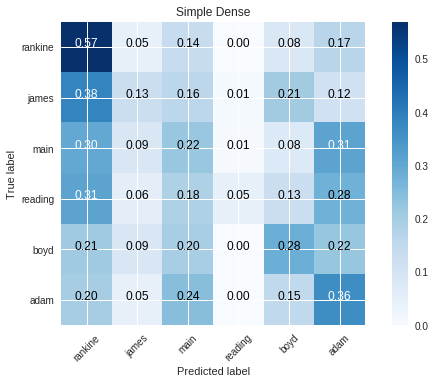

In [81]:
plot_confusion_matrix(model_1_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='Simple Dense')

##### Model 2 (ResNet 50)

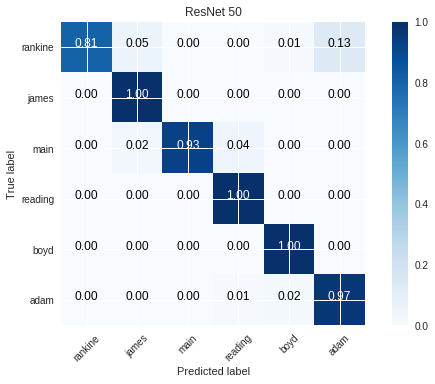

In [82]:
plot_confusion_matrix(model_2_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='ResNet 50')

##### Model 3 (VGG16)

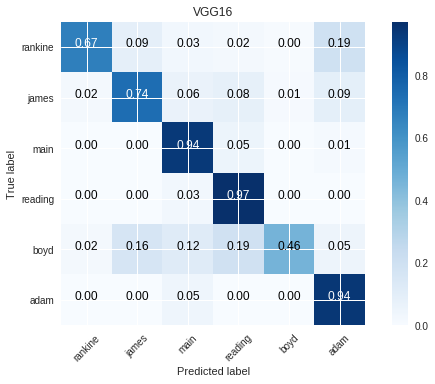

In [83]:
plot_confusion_matrix(model_3_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='VGG16')

##### Model 3 (VGG16, Dropout: 0.2)

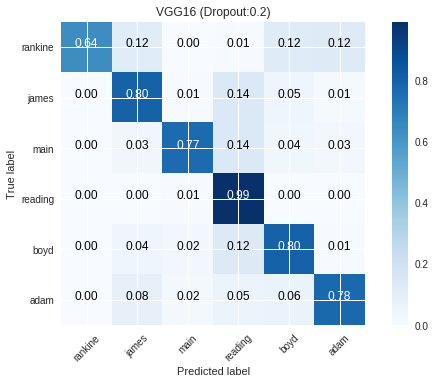

In [84]:
plot_confusion_matrix(model_3_dropout_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='VGG16 (Dropout:0.2)')

##### Model 3 (VGG16, Dropout: 0.5)

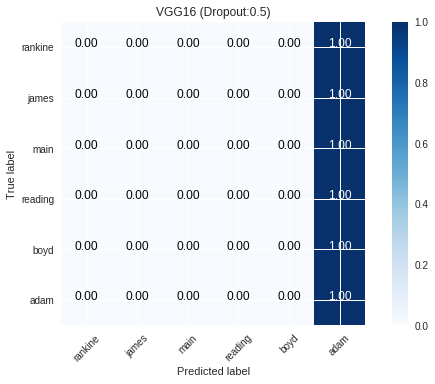

In [85]:
plot_confusion_matrix(model_3_dropout_aggressive_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='VGG16 (Dropout:0.5)')

As expected based on the high validation accurcy the ResNet 50 model achieved almost 100% accuracy however the confusion matrix does show that it had a slight issue differentiating between the Adam Smith building and the Rankine building. This is not surprising given the similar layout, colour and texture of buildings.

#### Training vs Validation Loss and Accuracy Analysis

##### Model 1 (Simple Dense)

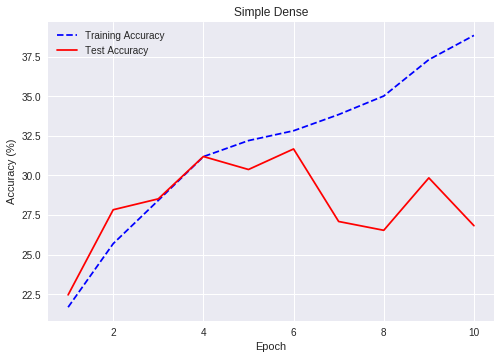

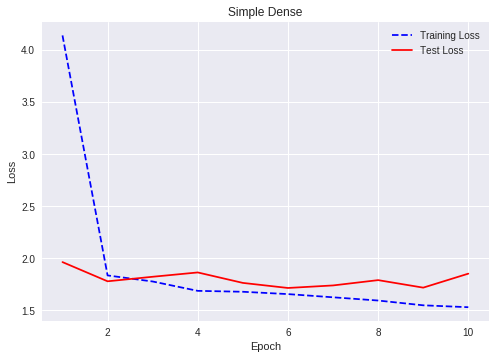

In [87]:
plot_accuracy(model_1_results["history"], "Simple Dense")
plot_loss(model_1_results["history"], "Simple Dense")

##### Model 2 (ResNet 50)

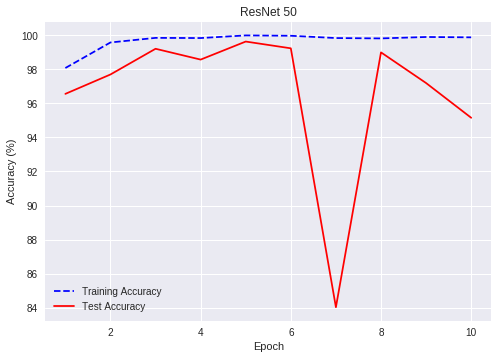

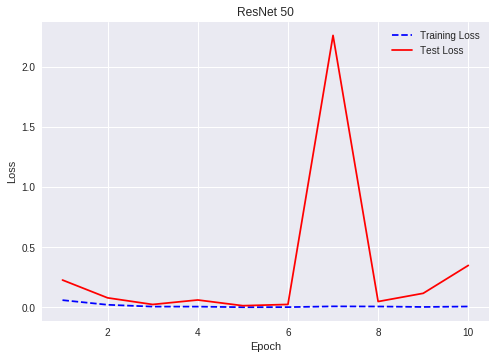

In [88]:
plot_accuracy(model_2_results["history"], "ResNet 50")
plot_loss(model_2_results["history"], "ResNet 50")

##### Model 3 (VGG16)

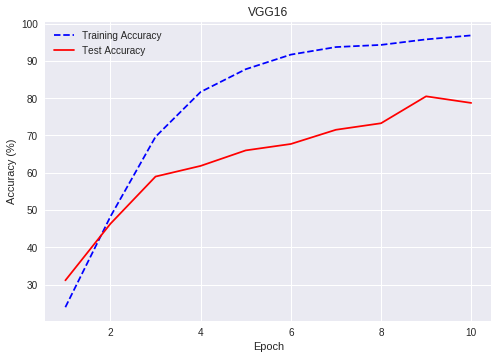

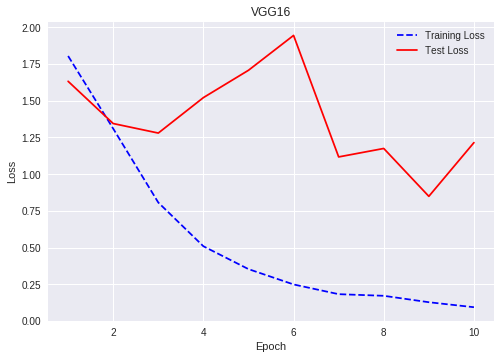

In [89]:
plot_accuracy(model_3_results["history"], "VGG16")
plot_loss(model_3_results["history"], "VGG16")

##### Model 3 (VGG16, Dropout: 0.2)

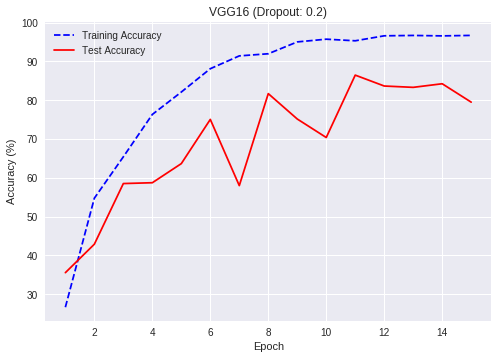

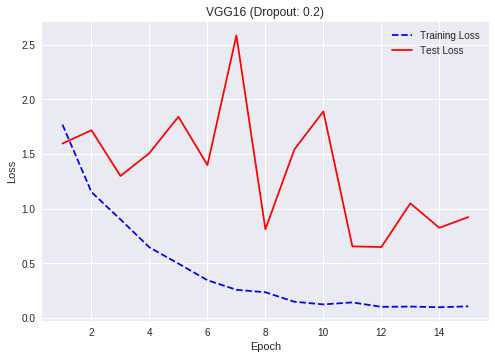

In [90]:
plot_accuracy(model_3_dropout_results["history"], "VGG16 (Dropout: 0.2)")
plot_loss(model_3_dropout_results["history"], "VGG16 (Dropout: 0.2)")

##### Model 3 (VGG16, Dropout: 0.5)

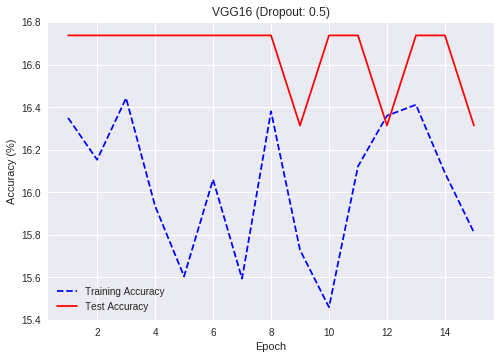

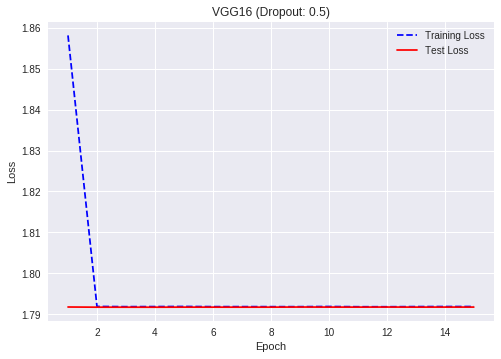

In [93]:
plot_accuracy(model_3_dropout_aggressive_results["history"], "VGG16 (Dropout: 0.5)")
plot_loss(model_3_dropout_aggressive_results["history"], "VGG16 (Dropout: 0.5)")

## Regularization
Based on the results, the ResNet 50 model has been selected to continue for further tuning.

From observing the training accuracy vs validation accuracy plot it is clear that the model is overfitting at epoch 7. At epoch 5 the training accuracy reaches 0.9999 and the validation accuracy reaches 0.9963, at this point the model can almost perfectly classify the data.

To try and avoid this sudden reduction in performance due to overfitting, regularization techniques will be investigated.

In [0]:
RESULTS_PATH_REG = RESULTS_PATH + 'regularization/'
make_path(RESULTS_PATH_REG)

In [0]:
RUN_BATCH = False
SAVE_BATCH = False

RUN_L2_1 = False
SAVE_L2_1 = False

RUN_L2_2 = False
SAVE_L2_2 = False

RUN_L2_3 = False
SAVE_L2_3 = False

RUN_BN_L2 = False
SAVE_BN_L2 = False

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [0]:
# same model as res50 however allows configuration of number of dense nodes and dense_layers
def res50_regularization(output_shape, pretrained=False,
                         batch_norm=False, use_l2=False, l2_val=0.001):
    if pretrained:
        base_model = ResNet50(include_top=False, weights="imagenet", pooling="avg")
        
    else:
        base_model = ResNet50(include_top=False, weights=None, pooling="avg")    
     
    if use_l2:
        x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_val))(base_model.output)
        
    else:
        x = Dense(1024, activation='relu')(base_model.output)
        
    if batch_norm:
        x = BatchNormalization()(x)

    predictions = Dense(output_shape, activation='softmax')(x)

    model = Model(base_model.input, predictions)
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

In [0]:
def run_evaluation(model, complete_index, partition, epochs=10, batch_size=64):
    # unfreeze batch normalization layers
    for layer in model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))

    # unfreeze top two blocks of ResNet
    for layer in model.layers[155:]:
            layer.trainable = True

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return evaluate_model(model, epochs,
                          partition["train"], partition["validation"],
                          complete_index, input_shape,
                          batch_size, len(labels))

### Batch Normalization

In [77]:
# returned model has all base layers frozen
model = res50_regularization(len(labels), pretrained=True, batch_norm=True)

if RUN_BATCH:
    results = run_evaluation(model, complete_index, partition)
    
if SAVE_BATCH:
    with open(RESULTS_PATH_REG + "bn.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 3s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
150/151 [============================>.] - ETA: 11s - loss: 0.0554 - acc: 0.9843

151/151 [==============================] - 2262s 15s/step - loss: 0.0554 - acc: 0.9843 - val_loss: 0.9861 - val_acc: 0.9219
Epoch 2/10
151/151 [==============================] - 222s 1s/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0124 - val_acc: 0.9939
Epoch 3/10
151/151 [==============================] - 221s 1s/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.7184 - val_acc: 0.8705
Epoch 4/10
151/151 [==============================] - 220s 1s/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0392 - val_acc: 0.9883
Epoch 5/10
151/151 [==============================] - 221s 1s/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0075 - val_acc: 0.9971
Epoch 6/10
151/151 [==============================] - 222s 1s/step

### L2

#### 0.1

In [84]:
# returned model has all base layers frozen
model = res50_regularization(len(labels), pretrained=True, batch_norm=False,
                             use_l2=True, l2_val=0.1)

if RUN_L2_1:
    results = run_evaluation(model, complete_index, partition)
    
if SAVE_L2_1:
    with open(RESULTS_PATH_REG + "l2_1.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/10
150/151 [============================>.] - ETA: 1s - loss: 12.1820 - acc: 0.9817

151/151 [==============================] - 250s 2s/step - loss: 12.1030 - acc: 0.9818 - val_loss: 0.4199 - val_acc: 0.9725
Epoch 2/10
151/151 [==============================] - 221s 1s/step - loss: 0.2056 - acc: 0.9892 - val_loss: 0.1995 - val_acc: 0.9823
Epoch 3/10
151/151 [==============================] - 223s 1s/step - loss: 0.2768 - acc: 0.9936 - val_loss: 0.9440 - val_acc: 0.9002
Epoch 4/10
151/151 [==============================] - 220s 1s/step - loss: 0.1720 - acc: 0.9960 - val_loss: 3.5159 - val_acc: 0.6668
Epoch 5/10
151/151 [==============================] - 221s 1s/step - loss: 0.1343 - acc: 0.9963 - val_loss: 0.0637 - val_acc: 0.9947
Epoch 6/10
151/151 [==============================] - 222s 1s/step - loss: 0.5402 - acc: 0.9954 - val_loss: 0.0845 - val_acc: 0.9989
Epoch 7/10
151/151 [==============================] - 221s 1s/step - loss: 0.0519 - acc: 0.9996 - val_loss: 0.0484 - va

#### 0.01

In [85]:
# returned model has all base layers frozen
model = res50_regularization(len(labels), pretrained=True, batch_norm=False,
                             use_l2=True, l2_val=0.01)

if RUN_L2_2:
    results = run_evaluation(model, complete_index, partition)
    
if SAVE_L2_2:
    with open(RESULTS_PATH_REG + "l2_2.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/10
150/151 [============================>.] - ETA: 1s - loss: 3.1105 - acc: 0.9780Epoch 1/10
Epoch 1/10
151/151 [==============================] - 255s 2s/step - loss: 3.0907 - acc: 0.9782 - val_loss: 0.5798 - val_acc: 0.9094
Epoch 2/10
151/151 [==============================] - 221s 1s/step - loss: 0.0937 - acc: 0.9938 - val_loss: 0.2755 - val_acc: 0.9658
Epoch 3/10
151/151 [==============================] - 220s 1s/step - loss: 0.0461 - acc: 0.9971 - val_loss: 0.0376 - val_acc: 0.9960
Epoch 4/10
151/151 [==============================] - 221s 1s/step - loss: 0.0706 - acc: 0.9962 - val_loss: 0.0300 - val_acc: 0.9952
Epoch 5/10
151/151 [==============================] - 223s 1s/step - loss: 0.0724 - acc: 0.9972 - val_loss: 0.1079 - val_acc: 0.9674
Epoch 6/10
151/151 [==============================] - 223s 1s/step - loss: 0.1385 - acc: 0.9942 - val_loss: 0.5427 - val_acc: 0.9574
Epoch 7/10
151/151 [==============================] - 222s 1s/step - loss: 0.0802 - acc: 0.9982 - val

#### 0.001

In [51]:
# returned model has all base layers frozen
model = res50_regularization(len(labels), pretrained=True, batch_norm=False,
                             use_l2=True, l2_val=0.001)

if RUN_L2_3:
    results = run_evaluation(model, complete_index, partition)
    
if SAVE_L2_3:
    with open(RESULTS_PATH_REG + "l2_3.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
150/151 [============================>.] - ETA: 1s - loss: 0.9831 - acc: 0.9801

151/151 [==============================] - 243s 2s/step - loss: 0.9798 - acc: 0.9802 - val_loss: 0.8779 - val_acc: 0.9510
Epoch 2/10
151/151 [==============================] - 219s 1s/step - loss: 0.3005 - acc: 0.9945 - val_loss: 0.1691 - val_acc: 0.9934
Epoch 3/10
151/151 [==============================] - 219s 1s/step - loss: 0.0991 - acc: 0.9983 - val_loss: 0.1241 - val_acc: 0.9801
Epoch 4/10
151/151 [==============================] - 220s 1s/step - loss: 0.0662 - acc: 0.9932 - val_loss: 0.7289 - val_acc: 0.8938
Epoch 5/10
151/151 [==============================] - 221s 1s/step - loss: 0.0605 - acc: 0.9962 - val_loss: 0.1260 - val_acc: 0.9899
Epoch 6/10
151/151 [==============================] - 220s 1s/step - loss: 0.0243 - acc: 0.9992 - val_loss: 0.0554 - val_acc: 0.9886
E

#### Batch Normalization + L2

In [0]:
# returned model has all base layers frozen
model = res50_regularization(len(labels), pretrained=True, batch_norm=True,
                             use_l2=True, l2_val=0.001)

if RUN_BN_L2:
    results = run_evaluation(model, complete_index, partition)
    
if SAVE_BN_L2:
    with open(RESULTS_PATH_REG + "bn_l2.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/10
150/151 [============================>.] - ETA: 1s - loss: 1.0974 - acc: 0.9851

151/151 [==============================] - 246s 2s/step - loss: 1.0945 - acc: 0.9852 - val_loss: 0.6688 - val_acc: 0.9942
Epoch 2/10
151/151 [==============================] - 220s 1s/step - loss: 0.4372 - acc: 0.9951 - val_loss: 2.6313 - val_acc: 0.8178
Epoch 3/10
151/151 [==============================] - 220s 1s/step - loss: 0.1951 - acc: 0.9969 - val_loss: 0.1229 - val_acc: 0.9992
Epoch 4/10
151/151 [==============================] - 221s 1s/step - loss: 0.1051 - acc: 0.9965 - val_loss: 0.0766 - val_acc: 0.9984
Epoch 5/10
151/151 [==============================] - 223s 1s/step - loss: 0.0606 - acc: 0.9981 - val_loss: 0.1064 - val_acc: 0.9846
Epoch 6/10
151/151 [==============================] - 222s 1s/step - loss: 0.0468 - acc: 0.9979 - val_loss: 0.0636 - val_acc: 0.9891
Epoch 7/10
151/151 [==============================] - 221s 1s/step - loss: 0.0504 - acc: 0.9971 - val_loss: 0.1067 - val_

### Compare Results

In [0]:
with open(RESULTS_PATH_REG + "bn.pkl", 'rb') as results_file:
    bn = pickle.load(results_file)
    
with open(RESULTS_PATH_REG + "l2_1.pkl", 'rb') as results_file:
    l2_1 = pickle.load(results_file)
    
with open(RESULTS_PATH_REG + "l2_2.pkl", 'rb') as results_file:
    l2_2 = pickle.load(results_file)
    
with open(RESULTS_PATH_REG + "l2_3.pkl", 'rb') as results_file:
    l2_3 = pickle.load(results_file)
    
with open(RESULTS_PATH_REG + "bn_l2.pkl", 'rb') as results_file:
    bn_l2 = pickle.load(results_file)

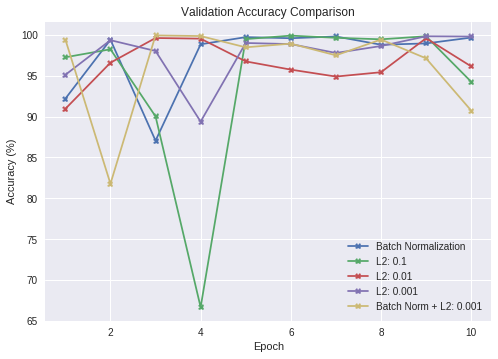

In [97]:
model_bn = np.array(bn["history"]["val_acc"]) * 100
model_l2_1 = np.array(l2_1["history"]["val_acc"]) * 100
model_l2_2 = np.array(l2_2["history"]["val_acc"]) * 100
model_l2_3 = np.array(l2_3["history"]["val_acc"]) * 100
model_bn_l2 = np.array(bn_l2["history"]["val_acc"]) * 100

epoch_count = range(1, len(model_bn) + 1)
plt.plot(epoch_count, model_bn, label="Batch Normalization", marker='X', markersize=6)
plt.plot(epoch_count, model_l2_1, label="L2: 0.1", marker='X', markersize=6)
plt.plot(epoch_count, model_l2_2, label="L2: 0.01", marker='X', markersize=6)
plt.plot(epoch_count, model_l2_3, label="L2: 0.001", marker='X', markersize=6)
plt.plot(epoch_count, model_bn_l2, label="Batch Norm + L2: 0.001", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.show()

The above graph shows that L2(0.1), L2(0.01) and the batch norm/L2 combination all begin to overfit in the final few epochs. The following graph will take at look at the batch normalization alone and compare it with the L2(0.001).

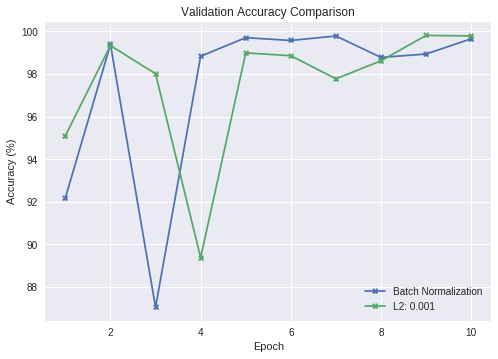

In [99]:
epoch_count = range(1, len(model_bn) + 1)
plt.plot(epoch_count, model_bn, label="Batch Normalization", marker='X', markersize=6)
plt.plot(epoch_count, model_l2_3, label="L2: 0.001", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.show()

### Batch Norm Extended Epochs

The batch norm looks to reach a higher accuracy earlier than the L2 method although the L2 finishes on a higher accuracy. The following code evaluates the batch norm for twice as many epochs to see if overfitting does eventually happen.

In [0]:
RUN_BATCH_EXTENDED = False
SAVE_BATCH_EXTENDED = False

In [102]:
# returned model has all base layers frozen
model = res50_regularization(len(labels), pretrained=True, batch_norm=True)

if RUN_BATCH_EXTENDED:
    results = run_evaluation(model, complete_index, partition, epochs=20)
    
if SAVE_BATCH_EXTENDED:
    with open(RESULTS_PATH_REG + "bn_ex.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 8s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
151/151 [==============================] - 3807s 25s/step - loss: 0.0587 - acc: 0.9837 - val_loss: 0.0707 - val_acc: 0.9886
Epoch 2/20
151/151 [==============================] - 216s 1s/step - loss: 0.0137 - acc: 0.9977 - val_loss: 0.0253 - val_acc: 0.9934
Epoch 3/20
151/151 [==============================] - 217s 1s/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0119 - val_acc: 0.9947
Epoch 4/20
151/151 [==============================] - 218s 1s/step - loss: 7.5782e-04 - acc: 0.9999 - val_loss: 0.0125 - val_acc: 0.9947
Epoch 5/20
151/151 [==============================] - 218s 1s/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0134 - val_acc: 0.9944
Epoch 6/20
151/151 [==============================] - 217s 1s/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0137 - val_acc: 0.9960
Epoch 7/20


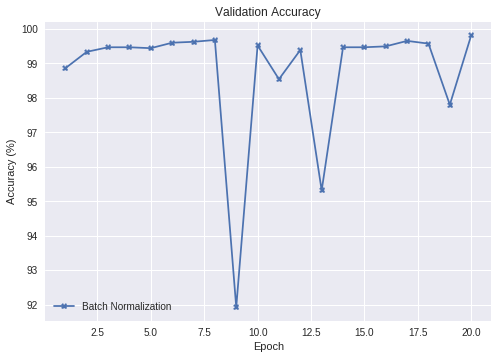

In [49]:
with open(RESULTS_PATH_REG + "bn_ex.pkl", 'rb') as results_file:
    bn_ex = pickle.load(results_file)
    
model_bn_ex = np.array(bn_ex["history"]["val_acc"]) * 100

epoch_count = range(1, len(model_bn_ex) + 1)
plt.plot(epoch_count, model_bn_ex, label="Batch Normalization", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.show()

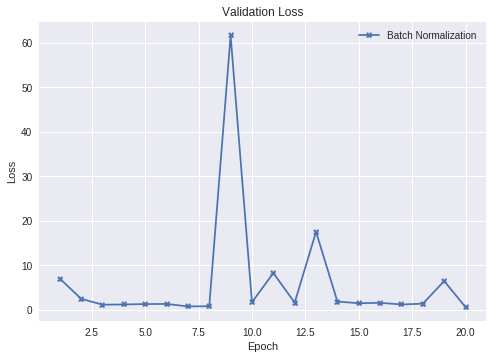

In [50]:
with open(RESULTS_PATH_REG + "bn_ex.pkl", 'rb') as results_file:
    bn_ex = pickle.load(results_file)
    
model_bn_ex = np.array(bn_ex["history"]["val_loss"]) * 100

epoch_count = range(1, len(model_bn_ex) + 1)
plt.plot(epoch_count, model_bn_ex, label="Batch Normalization", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.show()

Training for longer does seem to introduce more stability into the model however it does seem to have some issues from epoch 9 to14. As a result the model will only be trained to epoch 6 during the hyperparameter tuning. 

## Hyperparameter Tuning

Due to the lengthly time it takes to train the model and the limited processing power available only a manual search has been performed for two hyperparameters.

Ideally three fold cross-validation would be used for tuning with a fold for each day of recordings however due to the limited processing power available, the model will be trained on two of the days (15/02/2019, 17/02/2019) and evaluated on day (12_02_2019). This is using a different day for validation than the orignal model comparison and regularization selection. This is hoped to reduce the models bias towards the 15/02/2019 dataset as well as providing more insight into the models ability to generalize.

In [0]:
# same model as res50 (with batch norm) however allows configuration of number of dense nodes
def res50_tunable(output_shape, pretrained=False, nodes=1024):
    if pretrained:
        base_model = ResNet50(include_top=False, weights="imagenet", pooling="avg")
        
    else:
        base_model = ResNet50(include_top=False, weights=None, pooling="avg")
     
    x = Dense(nodes, activation='relu')(base_model.output)
    x = BatchNormalization()(x)
    predictions = Dense(output_shape, activation='softmax')(x)

    model = Model(base_model.input, predictions)
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

In [0]:
def split_data_by_day(data, validation_day):
    complete_index = {}
    partition = {'train':[], 'validation':[]} # contains list of training and validation ID's

    for day, buildings in data.items():
        for building, images in buildings.items():
            for img in images:
                if day == validation_day:
                    partition["validation"].append(img)
                    complete_index[img] = conversion_table[building]

                else:
                    partition["train"].append(img)
                    complete_index[img] = conversion_table[building]
                    
    return {"complete_index": complete_index,
            "partition":partition}

In [0]:
data = deepcopy(sub_sampled_index)
#Remove test day as used for final evalaution
del data["14_02_2019"]

In [0]:
split_by_day = split_data_by_day(data, "15_02_2019")
complete_index = split_by_day["complete_index"]
partition = split_by_day["partition"]

In [0]:
epochs = 6
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [0]:
RESULTS_PATH_HYPER = RESULTS_PATH + 'hyperparameter_search/'
make_path(RESULTS_PATH_HYPER)

### Dense Nodes
First we will investigate the number of dense nodes.

In [0]:
RUN_256 = False
SAVE_256 = False

RUN_512 = False
SAVE_512 = False

RUN_1024 = False
SAVE_1024 = False

In [112]:
# returned model has all base layers frozen
model = res50_tunable(len(labels), pretrained=True, nodes=256)

if RUN_256:
    results = run_evaluation(model, complete_index, partition, epochs=epochs)
    
if SAVE_256:
    with open(RESULTS_PATH_HYPER + "nodes_256.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/6
150/151 [============================>.] - ETA: 1s - loss: 0.0504 - acc: 0.9854Epoch 1/6
Epoch 1/6
151/151 [==============================] - 243s 2s/step - loss: 0.0502 - acc: 0.9854 - val_loss: 0.0422 - val_acc: 0.9918
Epoch 2/6
151/151 [==============================] - 218s 1s/step - loss: 0.0111 - acc: 0.9970 - val_loss: 0.0642 - val_acc: 0.9801
Epoch 3/6
151/151 [==============================] - 217s 1s/step - loss: 0.0055 - acc: 0.9982 - val_loss: 0.0081 - val_acc: 0.9981
Epoch 4/6
151/151 [==============================] - 218s 1s/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0068 - val_acc: 0.9976
Epoch 5/6
151/151 [==============================] - 219s 1s/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0194 - val_acc: 0.9934
Epoch 6/6
59/59 [==============================] - 40s 685ms/step


In [113]:
# returned model has all base layers frozen
model = res50_tunable(len(labels), pretrained=True, nodes=512)

if RUN_512:
    results = run_evaluation(model, complete_index, partition, epochs=epochs)
    
if SAVE_512:
    with open(RESULTS_PATH_HYPER + "nodes_512.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/6
151/151 [==============================] - 248s 2s/step - loss: 0.0507 - acc: 0.9837 - val_loss: 2.0748 - val_acc: 0.8181
Epoch 2/6
151/151 [==============================] - 219s 1s/step - loss: 0.0122 - acc: 0.9980 - val_loss: 0.0372 - val_acc: 0.9876
Epoch 3/6
151/151 [==============================] - 218s 1s/step - loss: 0.0102 - acc: 0.9980 - val_loss: 0.7009 - val_acc: 0.8832
Epoch 4/6
151/151 [==============================] - 219s 1s/step - loss: 0.0055 - acc: 0.9990 - val_loss: 1.0165 - val_acc: 0.8999
Epoch 5/6
151/151 [==============================] - 218s 1s/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0130 - val_acc: 0.9963
Epoch 6/6
59/59 [==============================] - 42s 713ms/step


In [114]:
# returned model has all base layers frozen
model = res50_tunable(len(labels), pretrained=True, nodes=1024)

if RUN_1024:
    results = run_evaluation(model, complete_index, partition, epochs=epochs)
    
if SAVE_1024:
    with open(RESULTS_PATH_HYPER + "nodes_1024.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/6
151/151 [==============================] - 255s 2s/step - loss: 0.0602 - acc: 0.9827 - val_loss: 0.0507 - val_acc: 0.9804
Epoch 2/6
151/151 [==============================] - 219s 1s/step - loss: 0.0074 - acc: 0.9982 - val_loss: 0.0679 - val_acc: 0.9849
Epoch 3/6
151/151 [==============================] - 219s 1s/step - loss: 0.0112 - acc: 0.9976 - val_loss: 0.4721 - val_acc: 0.9288
Epoch 4/6
151/151 [==============================] - 219s 1s/step - loss: 0.0085 - acc: 0.9978 - val_loss: 0.0340 - val_acc: 0.9870
Epoch 5/6
151/151 [==============================] - 220s 1s/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0083 - val_acc: 0.9966
Epoch 6/6
59/59 [==============================] - 44s 740ms/step


### Dense Results

In [0]:
with open(RESULTS_PATH_HYPER + "nodes_256.pkl", 'rb') as results_file:
    nodes_256 = pickle.load(results_file)
    
with open(RESULTS_PATH_HYPER + "nodes_512.pkl", 'rb') as results_file:
    nodes_512 = pickle.load(results_file)
    
with open(RESULTS_PATH_HYPER + "nodes_1024.pkl", 'rb') as results_file:
    nodes_1024 = pickle.load(results_file)

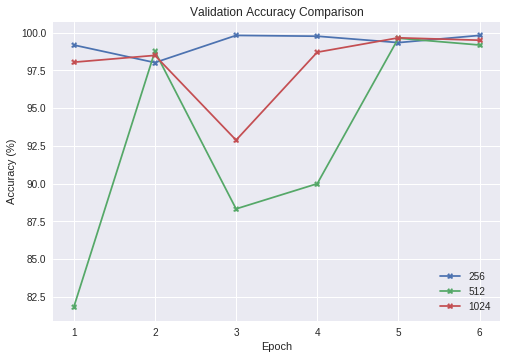

In [118]:
model_nodes_256 = np.array(nodes_256["history"]["val_acc"]) * 100
model_nodes_512 = np.array(nodes_512["history"]["val_acc"]) * 100
model_nodes_1024 = np.array(nodes_1024["history"]["val_acc"]) * 100

epoch_count = range(1, len(model_nodes_256) + 1)
plt.plot(epoch_count, model_nodes_256, label="256", marker='X', markersize=6)
plt.plot(epoch_count, model_nodes_512, label="512", marker='X', markersize=6)
plt.plot(epoch_count, model_nodes_1024, label="1024", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.show()

From the graph it is shown that the 256 node version outperformed the 512 and 1024 for the first four epochs. By the sixth epoch all models had converged to a similiar level of accuracy. Due to it's lack of fluctuation, the 256 node version will be continued for further investigation. 

### Batch Size

In [0]:
RUN_32 = False
SAVE_32 = False

RUN_64 = False
SAVE_64 = False

In [121]:
# returned model has all base layers frozen
model = res50_tunable(len(labels), pretrained=True, nodes=256)

if RUN_32:
    results = run_evaluation(model, complete_index, partition, epochs=epochs, batch_size=32)
    
if SAVE_32:
    with open(RESULTS_PATH_HYPER + "batch_32.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/6
302/302 [==============================] - 292s 967ms/step - loss: 0.0764 - acc: 0.9797 - val_loss: 0.0126 - val_acc: 0.9984
Epoch 2/6
302/302 [==============================] - 251s 832ms/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0308 - val_acc: 0.9915
Epoch 3/6
302/302 [==============================] - 252s 834ms/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0230 - val_acc: 0.9910
Epoch 4/6
302/302 [==============================] - 252s 835ms/step - loss: 0.0065 - acc: 0.9981 - val_loss: 0.0234 - val_acc: 0.9939
Epoch 5/6
302/302 [==============================] - 251s 832ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.0167 - val_acc: 0.9944
Epoch 6/6
118/118 [==============================] - 49s 416ms/step


In [122]:
# returned model has all base layers frozen
model = res50_tunable(len(labels), pretrained=True, nodes=256)

if RUN_64:
    results = run_evaluation(model, complete_index, partition, epochs=epochs, batch_size=64)
    
if SAVE_64:
    with open(RESULTS_PATH_HYPER + "batch_64.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Epoch 1/6
151/151 [==============================] - 268s 2s/step - loss: 0.0509 - acc: 0.9854 - val_loss: 0.0949 - val_acc: 0.9785
Epoch 2/6
151/151 [==============================] - 220s 1s/step - loss: 0.0076 - acc: 0.9983 - val_loss: 0.0266 - val_acc: 0.9931
Epoch 3/6
151/151 [==============================] - 219s 1s/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0412 - val_acc: 0.9876
Epoch 4/6
151/151 [==============================] - 219s 1s/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.5473 - val_acc: 0.9179
Epoch 5/6
151/151 [==============================] - 219s 1s/step - loss: 0.0032 - acc: 0.9992 - val_loss: 0.1314 - val_acc: 0.9711
Epoch 6/6
59/59 [==============================] - 50s 845ms/step


### Batch Size Results

In [0]:
with open(RESULTS_PATH_HYPER + "batch_32.pkl", 'rb') as results_file:
    batch_32 = pickle.load(results_file)
    
with open(RESULTS_PATH_HYPER + "batch_64.pkl", 'rb') as results_file:
    batch_64 = pickle.load(results_file)

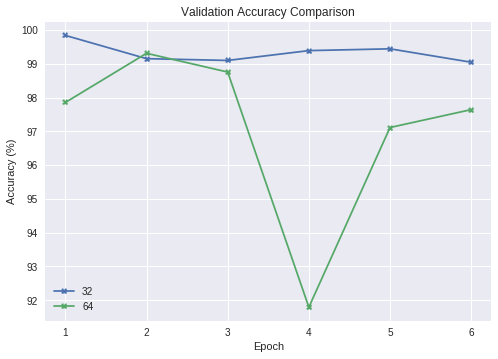

In [124]:
model_batch_32 = np.array(batch_32["history"]["val_acc"]) * 100
model_batch_64 = np.array(batch_64["history"]["val_acc"]) * 100

epoch_count = range(1, len(model_batch_32) + 1)
plt.plot(epoch_count, model_batch_32, label="32", marker='X', markersize=6)
plt.plot(epoch_count, model_batch_64, label="64", marker='X', markersize=6)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.show()

# Evaluation

Train on days 12/02/2019, 15/02/2019, 17/02/2019 and evalaute on 14/02/2019

Data collected on 14/02/2019 is completely unseen to the model.

In [0]:
epochs = 6 # Chosen based on model performance

In [0]:
RUN_UNSEEN_DAY = True
SAVE_UNSEEN_DAY = True

In [0]:
# Create folder to save results
RESULTS_PATH_FINAL = RESULTS_PATH + 'final_evaluation/'
make_path(RESULTS_PATH_FINAL)

In [0]:
data = deepcopy(sub_sampled_index)

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [0]:
split_by_day = split_data_by_day(data, "14_02_2019")
complete_index = split_by_day["complete_index"]
partition = split_by_day["partition"]

In [59]:
# returned model has all base layers frozen
model = res50_tunable(len(labels), pretrained=True, nodes=256)

if RUN_UNSEEN_DAY:
    results = run_evaluation(model, complete_index, partition, epochs=epochs, batch_size=32)
    
if SAVE_UNSEEN_DAY:
    with open(RESULTS_PATH_FINAL + "unseen_day.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/6
420/420 [==============================] - 1268s 3s/step - loss: 0.0550 - acc: 0.9826 - val_loss: 1.3199 - val_acc: 0.8565
Epoch 2/6
420/420 [==============================] - 324s 771ms/step - loss: 0.0132 - acc: 0.9961 - val_loss: 0.0309 - val_acc: 0.9932
Epoch 3/6
420/420 [==============================] - 325s 775ms/step - loss: 0.0053 - acc: 0.9989 - val_loss: 8.9617e-05 - val_acc: 1.0000
Epoch 4/6
420/420 [==============================] - 327s 778ms/step - loss: 0.0083 - acc: 0.9981 - val_loss: 0.0040 - val_acc: 0.9982
Epoch 5/6
420/420 [==============================] - 327s 779ms/step - loss: 0.0046 - acc: 0.9992 - val_loss: 2.6211e-04 - val_acc: 1.0000
Epoch 6/6
105/105 [==============================] - 35s 329ms/step


In [0]:
with open(RESULTS_PATH_FINAL + "unseen_day.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Accuracy and Loss

In [61]:
print("Test Accuracy:", results["history"]["val_acc"][-1])
print("Test Loss:", results["history"]["val_loss"][-1])

Test Accuracy: 1.0
Test Loss: 5.060398638485302e-05


## Confusion Matrix

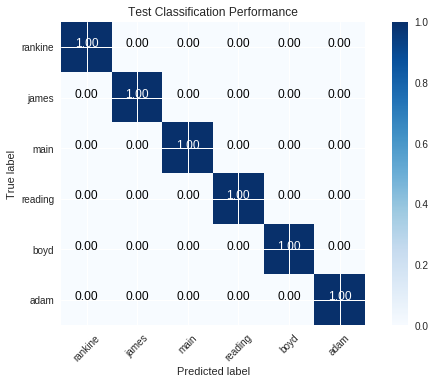

In [62]:
plot_confusion_matrix(results["confusion_matrix"], confusion_labels,
                      normalize=True, title='Test Classification Performance')

## Performance Over Epoch Analysis

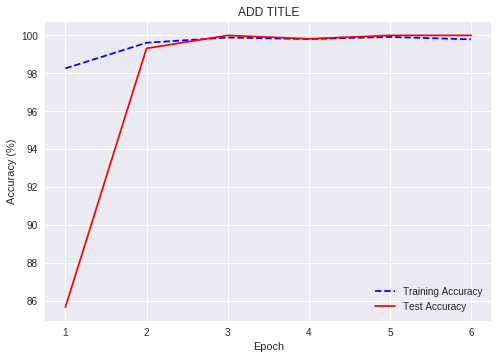

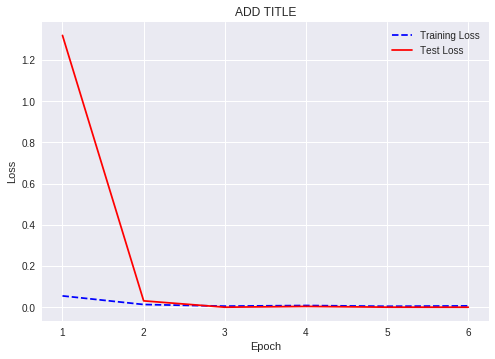

In [64]:
plot_accuracy(results["history"], "ADD TITLE")
plot_loss(results["history"], "ADD TITLE")

# Conclusion 



*   construction work
*   weather conditions such as fog and snow
*   full perimeter often unavailable due to construction
*   lack of variation in distance (not any images from far away)
*   only one camera used
*   variations in lighting only simualted, no evening images

